# Real-world Data Science: Applications of Visualizations
## Zexi Han

In [1]:
# load libraries
import warnings
warnings.filterwarnings('ignore')

import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.data.path.append("/Users/zexihan/Developer/nltk_data")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

## 1. Explore the data

In [2]:
wine_reviews = pd.read_csv("wine-reviews/winemag-data-130k-v2.csv")

In [3]:
wine_reviews.shape

(129971, 14)

In [4]:
wine_reviews.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

Categorical:
- country: The country that the wine is from
- designation: The vineyard within the winery where the grapes that made the wine are from
- province: The province or state that the wine is from
- region_1: The wine growing area in a province or state (ie Napa)
- region_2: Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank
- variety: The type of grapes used to make the wine (ie Pinot Noir)
- winery: The winery that made the wine
- three new attributes: title, taster_name, taster_twitter_handle

Quantitative
- points: The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
- price: The cost for a bottle of the wine

Text description
- description: A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.

In [5]:
wine_reviews.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Visualization 1-2

Text(0, 0.5, 'Frequency')

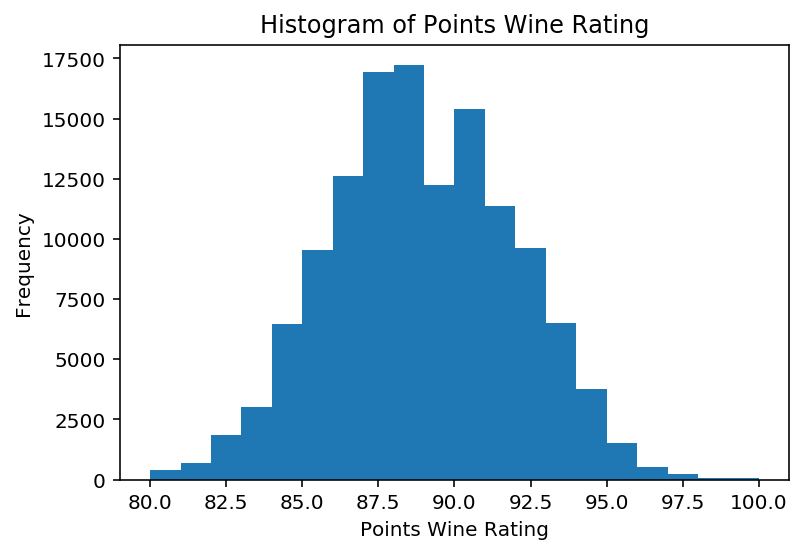

In [6]:
# distribution of the points
plt.hist(wine_reviews["points"], bins=20)
plt.title("Histogram of Points Wine Rating")
plt.xlabel("Points Wine Rating")
plt.ylabel("Frequency")

In [7]:
# variety
wine_reviews["variety"].unique().shape

(708,)

Text(0, 0.5, 'Frequency')

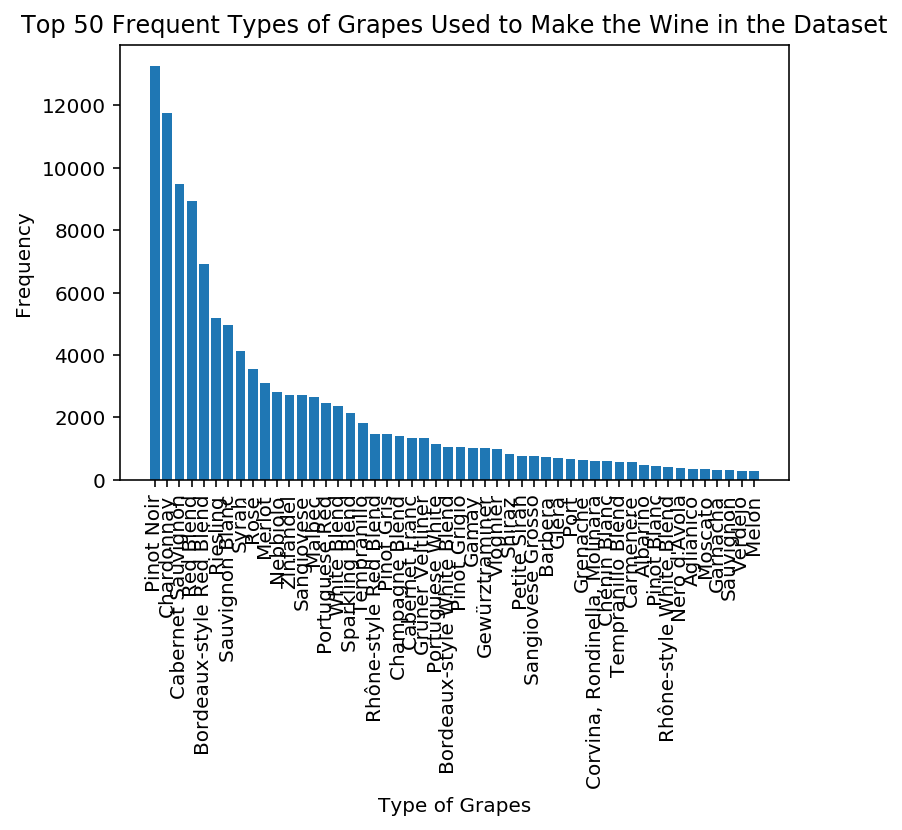

In [8]:
variety_count = pd.DataFrame({'count' : wine_reviews.groupby("variety").size()}) \
                .reset_index() \
                .sort_values("count", ascending=False) \
                .head(50)
plt.bar(variety_count["variety"], variety_count["count"])
plt.xticks(rotation='vertical')
plt.title("Top 50 Frequent Types of Grapes Used to Make the Wine in the Dataset")
plt.xlabel("Type of Grapes")
plt.ylabel("Frequency")

## 2. Split the dataset randomly into train/test (80/20)

In [9]:
wine_reviews = wine_reviews.sample(10000)

In [10]:
X = wine_reviews.drop("points", axis=1)
y = wine_reviews["points"]
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                    test_size=0.2, random_state=42)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 13), (2000, 13), (8000,), (2000,))

## 3. Preprocess the data

### a. one-hot encoding for categorical features

In [12]:
print("Number of levels of categorical variables")
print("country: {}".format(wine_reviews["country"].unique().shape[0]))
print("designation: {}".format(wine_reviews["designation"].unique().shape[0]))
print("province: {}".format(wine_reviews["province"].unique().shape[0]))
print("region_1: {}".format(wine_reviews["region_1"].unique().shape[0]))
print("region_2: {}".format(wine_reviews["region_2"].unique().shape[0]))
print("variety: {}".format(wine_reviews["variety"].unique().shape[0]))
print("winery: {}".format(wine_reviews["winery"].unique().shape[0]))
print("title: {}".format(wine_reviews["title"].unique().shape[0]))
print("taster_name: {}".format(wine_reviews["taster_name"].unique().shape[0]))
print("taster_twitter_handle: {}".format(wine_reviews["taster_twitter_handle"].unique().shape[0]))

Number of levels of categorical variables
country: 35
designation: 5362
province: 259
region_1: 728
region_2: 18
variety: 353
winery: 5531
title: 9927
taster_name: 19
taster_twitter_handle: 15


#### Process the variables with a large number of levels: designation, winery

In [13]:
# replace the tail categories of the categorical variable with 'Others'
def reduce(df_train, df_test, col_name, dimension):
    top_categories = set(pd.DataFrame({'count' : df_train.groupby(col_name).size()}) \
                        .reset_index() \
                        .sort_values("count", ascending=False) \
                        .head(dimension)[col_name])
    
    df_train["reduced_" + col_name] = df_train[col_name]
    df_train.loc[~df_train["reduced_" + col_name].isin(top_categories), "reduced_" + col_name] = "Others"
    df_train["reduced_" + col_name].unique().shape[0]
    
    df_test["reduced_" + col_name] = df_test[col_name]
    df_test.loc[~df_test["reduced_" + col_name].isin(top_categories), "reduced_" + col_name] = "Others"
    df_test["reduced_" + col_name].unique().shape[0]

In [14]:
reduce(X_train, X_test, "designation", 100)
reduce(X_train, X_test, "winery", 100)
reduce(X_train, X_test, "province", 100)
reduce(X_train, X_test, "region_1", 100)

In [15]:
X_train.columns, X_test.columns

(Index(['Unnamed: 0', 'country', 'description', 'designation', 'price',
        'province', 'region_1', 'region_2', 'taster_name',
        'taster_twitter_handle', 'title', 'variety', 'winery',
        'reduced_designation', 'reduced_winery', 'reduced_province',
        'reduced_region_1'],
       dtype='object'),
 Index(['Unnamed: 0', 'country', 'description', 'designation', 'price',
        'province', 'region_1', 'region_2', 'taster_name',
        'taster_twitter_handle', 'title', 'variety', 'winery',
        'reduced_designation', 'reduced_winery', 'reduced_province',
        'reduced_region_1'],
       dtype='object'))

#### Encoding

In [16]:
X_train_cat_label = X_train[["country", "reduced_province", "reduced_region_1", "region_2", "taster_name", \
                 "variety", "reduced_designation", "reduced_winery"]].astype(str)
X_train_cat_label.fillna("Others")

X_test_cat_label = X_test[["country", "reduced_province", "reduced_region_1", "region_2", "taster_name", \
                 "variety", "reduced_designation", "reduced_winery"]].astype(str)
X_test_cat_label.fillna("Others")

X_train_cat_label.shape, X_test_cat_label.shape

((8000, 8), (2000, 8))

In [17]:
enc = OneHotEncoder()
X_temp = pd.concat([X_train_cat_label, X_test_cat_label], ignore_index=True, sort=False)
enc.fit(X_temp)
X_train_cat_onehot = enc.transform(X_train_cat_label).toarray()
X_test_cat_onehot = enc.transform(X_test_cat_label).toarray()
X_train_cat_onehot.shape, X_test_cat_onehot.shape

((8000, 829), (2000, 829))

### b. standardization for continuous features

In [18]:
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)

X_train_con = X_train[["price"]]
X_test_con = X_test[["price"]]
scaler = StandardScaler()
scaler.fit(X_train_con)
X_train_con_scaled = scaler.transform(X_train_con)
X_test_con_scaled = scaler.transform(X_test_con)

### c. TF-IDF matrices and LDA for the text description

#### clean text

In [19]:
X_train["description"].head()

68607     Vintner Elena Walch offers this fine Sauvignon...
25074     Although drinking this wine while fishing woul...
89291     Lovely, fresh and lightly sparkling, this vibr...
16294     Simple brown sugar scents make for a monotone ...
115156    Wonderfully pure notes of mandarin and tart ap...
Name: description, dtype: object

In [20]:
def clean_text(df): 
    X_description = []
    for i, description in enumerate(df["description"]):
        description = description.lower()
        tokenizer = RegexpTokenizer(r'\w+')
        word_tokens = tokenizer.tokenize(description) 
        filtered_description = [w for w in word_tokens if not w in stopwords.words('english')]
        X_description.append(" ".join(filtered_description))
        if i % 100 == 0:
            print("Progress: {}".format(i), end='\r', flush=True)
    return X_description

In [21]:
X_train_description = clean_text(X_train)
X_test_description = clean_text(X_test)

#### TF-IDF and LDA

In [22]:
tvec = TfidfVectorizer()
tvec.fit(X_train_description)
X_train_description_tvec = tvec.transform(X_train_description)
X_test_description_tvec = tvec.transform(X_test_description)
X_train_description_tvec.shape, X_test_description_tvec.shape

((8000, 10488), (2000, 10488))

In [23]:
lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(X_train_description_tvec)
X_train_description_tvec_lda = lda.transform(X_train_description_tvec) 
X_test_description_tvec_lda = lda.transform(X_test_description_tvec) 
X_train_description_tvec_lda.shape, X_test_description_tvec_lda.shape

((8000, 20), (2000, 20))

### Merge the preprocessed features

In [24]:
X_train_cat_onehot.shape, X_train_con_scaled.shape, X_train_description_tvec_lda.shape

((8000, 829), (8000, 1), (8000, 20))

In [25]:
X_test_cat_onehot.shape, X_test_con_scaled.shape, X_test_description_tvec_lda.shape

((2000, 829), (2000, 1), (2000, 20))

In [26]:
X_train_preprocessed = np.concatenate((X_train_cat_onehot, X_train_con_scaled, \
                                       X_train_description_tvec_lda), axis=1)
X_test_preprocessed = np.concatenate((X_test_cat_onehot, X_test_con_scaled, \
                                      X_test_description_tvec_lda), axis=1)
X_train_preprocessed.shape, X_test_preprocessed.shape

((8000, 850), (2000, 850))

In [58]:
variable_names = \
["country_" + str(x) for x in range(35)] + \
["province_" + str(x) for x in range(101)] + \
["region_1_" + str(x) for x in range(101)] + \
["region_2_" + str(x) for x in range(18)] + \
["taster_name_" + str(x) for x in range(19)] + \
["variety_" + str(x) for x in range(353)] + \
["designation_" + str(x) for x in range(101)] + \
["winery_" + str(x) for x in range(101)] + \
["price"] + \
["description_" + str(x) for x in range(20)]
len(variable_names)

850

## 4 Train models

In [44]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import dask_searchcv as dcv
from dask.diagnostics import ProgressBar

### Ridge regression

In [45]:
parameters = {'alpha': [0.05, 0.01, 0.02, 0.05, 0.1]}
mse = make_scorer(mean_squared_error)
ridge = Ridge()
ridge_regressor = dcv.GridSearchCV(estimator=ridge, param_grid=parameters, scoring=mse, \
                                   cv=10, return_train_score=True)
with ProgressBar():
    ridge_regressor.fit(X_train_preprocessed, y_train)

[########################################] | 100% Completed |  5.4s


In [46]:
ridge_regressor.best_score_, ridge_regressor.best_params_

(6.224221596013711, {'alpha': 0.01})

In [60]:
ridge_results = pd.DataFrame(ridge_regressor.cv_results_)

### Bagging

In [52]:
parameters = {'n_estimators': [25, 50, 100], \
              'max_samples': [0.8, 0.9, 1.0], \
              'max_features': [0.8, 0.9, 1.0]}
mse = make_scorer(mean_squared_error)
bagging = BaggingRegressor()
bagging_regressor = dcv.GridSearchCV(estimator=bagging, param_grid=parameters, scoring=mse, \
                                     cv=10, return_train_score=True, n_jobs=4)
with ProgressBar():
    bagging_regressor.fit(X_train_preprocessed, y_train)

[########################################] | 100% Completed | 39min 14.6s


In [53]:
bagging_regressor.best_score_, bagging_regressor.best_params_

(4.3382474, {'max_features': 1.0, 'max_samples': 0.8, 'n_estimators': 25})

In [61]:
bagging_results = pd.DataFrame(bagging_regressor.cv_results_)

### Gradient boosting

In [55]:
parameters = {'learning_rate': [0.05, 0.1, 0.2], \
              'n_estimators': [25, 50, 100], \
              'subsample': [0.8, 0.9, 1.0]}
mse = make_scorer(mean_squared_error)
gb = GradientBoostingRegressor()
gb_regressor = dcv.GridSearchCV(estimator=gb, param_grid=parameters, scoring=mse, \
                                cv=10, return_train_score=True)
with ProgressBar():
    gb_regressor.fit(X_train_preprocessed, y_train)

[########################################] | 100% Completed | 27min 19.8s


In [56]:
gb_regressor.best_score_, gb_regressor.best_params_

(5.343273900704527,
 {'learning_rate': 0.05, 'n_estimators': 25, 'subsample': 1.0})

In [62]:
gb_results = pd.DataFrame(gb_regressor.cv_results_)

## 5 Visualization 3
Comparing the performance of the 3 different models with their optimal hyperparameters.

## 6 Visualization 4
Showing the top features learned by the best performing model.